<a href="https://colab.research.google.com/github/raphaelp-silva/deep_learning_com_pytorch_e_python/blob/main/Tarefa_previs%C3%A3o_do_valor_total_de_vendas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Etapa 1: Importando as bibliotecas

In [8]:
import pandas as pd
import torch
from torch import nn, optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
torch.__version__

'2.5.1+cu124'

##Etapa 2: Base de dados

In [3]:
torch.manual_seed(123)

In [4]:
base = pd.read_csv('/content/games.csv')

In [5]:
base.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
base.shape

(16719, 16)

In [7]:
base = base.drop('Name', axis = 1)
base = base.drop('Other_Sales', axis = 1)
base = base.drop('Developer', axis = 1)
base = base.drop('NA_Sales', axis = 1)
base = base.drop('EU_Sales', axis = 1)
base = base.drop('JP_Sales', axis = 1)

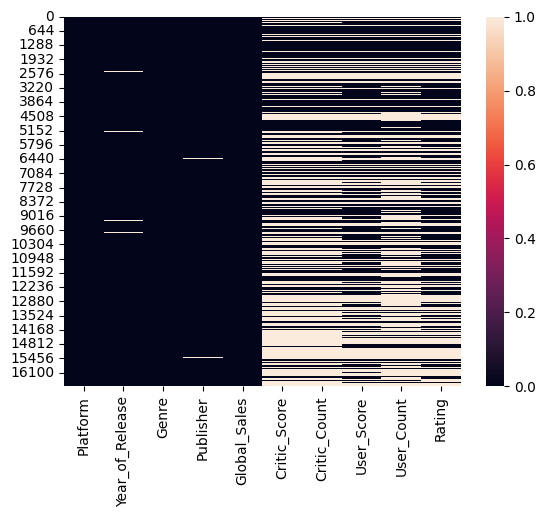

In [9]:
sns.heatmap(base.isnull()); #conferindo se temos colunas com valores nulos

In [10]:
base = base.dropna(axis = 0) # excluindo as colunas com valores nulos.

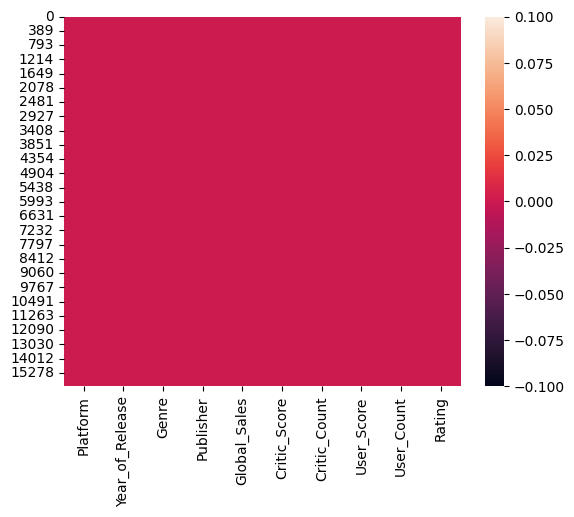

In [11]:
sns.heatmap(base.isnull()); # confirmando se ainda existem colunas com valores nulos.

In [13]:
base.shape # verificando o tamanho da tabela

(6825, 10)

In [15]:
base = base.loc[base['Global_Sales'] > 1] # filtrando apenas os registros onde na coluna 'global_sales' tem valor maior que 1

In [16]:
base.shape # verificando novamente o tamanho da tabela (repare que houve uma diminuição nos registros)

(1307, 10)

In [20]:
base.head()

,Platform,Year_of_Release,Genre,Publisher,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Rating
0,Wii,2006.0,Sports,Nintendo,82.53,76.0,51.0,8,322.0,E
2,Wii,2008.0,Racing,Nintendo,35.52,82.0,73.0,8.3,709.0,E
3,Wii,2009.0,Sports,Nintendo,32.77,80.0,73.0,8,192.0,E
6,DS,2006.0,Platform,Nintendo,29.80,89.0,65.0,8.5,431.0,E
7,Wii,2006.0,Misc,Nintendo,28.92,58.0,41.0,6.6,129.0,E


In [24]:
# criando previsores e valor de vendas:
previsores = base.iloc[:,[0,1,2,3,5,6,7,8,9]].values # selecionando todas as linhas e as colunas específicas (retirando a coluna global_sales)
vendas = base.iloc[:,4].values # selecionando os valores de todas as linhas da coluna 4 (global_sales).

In [25]:
previsores #valores das colunas 0,1,2,3,5,6,7,8,9

array([['Wii', 2006.0, 'Sports', ..., '8', 322.0, 'E'],
       ['Wii', 2008.0, 'Racing', ..., '8.3', 709.0, 'E'],
       ['Wii', 2009.0, 'Sports', ..., '8', 192.0, 'E'],
       ...,
       ['X360', 2008.0, 'Action', ..., '7', 189.0, 'T'],
       ['WiiU', 2012.0, 'Action', ..., '7.7', 758.0, 'M'],
       ['WiiU', 2016.0, 'Fighting', ..., '8', 273.0, 'E10+']],
      dtype=object)

In [26]:
vendas #valores da coluna 4

array([82.53, 35.52, 32.77, ...,  1.01,  1.01,  1.01])

In [27]:
# transformando colunas categóricas em valores binários:

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

onehotencoder = ColumnTransformer(transformers=[('OneHot', OneHotEncoder(), [0,2,3,8])], remainder='passthrough')
previsores = onehotencoder.fit_transform(previsores).toarray()

In [29]:
previsores.shape

(1307, 99)

In [31]:
# convertendo os dados para o formato de tensor
previsores = torch.tensor(previsores, dtype=torch.float)
vendas = torch.tensor(vendas, dtype=torch.float)

In [32]:
# criando um conjunto de dados com previsores e vendas
# criando um dataloader com 10 exemplos/vez
dataset = torch.utils.data.TensorDataset(previsores, vendas)
train_loader = torch.utils.data.DataLoader(dataset, batch_size = 10, shuffle=True)

## Etapa 3: Construção do modelo

In [33]:
# 99 -> 50 -> 50 -> 1 // estrutura da rede neural

# definindo os atributos da rede:
class regressor_torch(nn.Module):
  def __init__(self):
    super().__init__()
    self.dense0 = nn.Linear(99, 50)
    self.dense1 = nn.Linear(50, 50)
    self.activation = nn.Sigmoid()
    self.output = nn.Linear(50, 1)

# ligando a rede neural:
  def forward(self, X):
    X = self.dense0(X)
    X = self.activation(X)
    X = self.dense1(X)
    X = self.activation(X)
    X = self.output(X)
    return X

In [34]:
# criando uma variavel que recebe a classe regressor_torch
regressor = regressor_torch()

In [35]:
# configurando a função de perda e o otimizador da rede
criterion = nn.MSELoss()
optimizer = optim.Adam(regressor.parameters())

## Etapa 4: Treinamento do modelo

In [36]:
# verificando se há GPU disponível para executar, caso não, utilizará CPU.
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [37]:
# movendo o modelo para o dispositivo setado acima
regressor.to(device)

regressor_torch(
  (dense0): Linear(in_features=99, out_features=50, bias=True)
  (dense1): Linear(in_features=50, out_features=50, bias=True)
  (activation): Sigmoid()
  (output): Linear(in_features=50, out_features=1, bias=True)
)

In [42]:
for epoch in range(5000):

  running_loss = 0.
  running_mse = 0.

  for i, data in enumerate(train_loader):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = regressor(inputs)
    mse = F.mse_loss(outputs, labels).item()
    running_mse += mse

    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    loss = loss.item()
    running_loss += loss

    print(f'\rÉPOCA {epoch+1:3d} - Loop {i+1:3d} de {len(previsores)//100:3d}: perda {loss:06.2f} - MSE {mse:06.2f}', end='\r')
  print(f'Época {epoch+1} finalizada: perda {running_loss/len(train_loader):.5f} - MSE {running_mse/len(train_loader):.5f}')


<ipython-input-42-c523cb0a099c>:12: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mse = F.mse_loss(outputs, labels).item()


Época 1 finalizada: perda 14.65769 - MSE 14.65769


<ipython-input-42-c523cb0a099c>:12: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mse = F.mse_loss(outputs, labels).item()


Época 2 finalizada: perda 14.60810 - MSE 14.60810
Época 3 finalizada: perda 14.66362 - MSE 14.66362
Época 4 finalizada: perda 14.60013 - MSE 14.60013
Época 5 finalizada: perda 14.60522 - MSE 14.60522
Época 6 finalizada: perda 14.61630 - MSE 14.61630
Época 7 finalizada: perda 14.62508 - MSE 14.62508
Época 8 finalizada: perda 14.63255 - MSE 14.63255
Época 9 finalizada: perda 14.59342 - MSE 14.59342
Época 10 finalizada: perda 14.61071 - MSE 14.61071
Época 11 finalizada: perda 14.64907 - MSE 14.64907
Época 12 finalizada: perda 14.59113 - MSE 14.59113
Época 13 finalizada: perda 14.62659 - MSE 14.62659
Época 14 finalizada: perda 14.62769 - MSE 14.62769
Época 15 finalizada: perda 14.63990 - MSE 14.63990
Época 16 finalizada: perda 14.63208 - MSE 14.63208
Época 17 finalizada: perda 14.61054 - MSE 14.61054
Época 18 finalizada: perda 14.61495 - MSE 14.61495
Época 19 finalizada: perda 14.73554 - MSE 14.73554
Época 20 finalizada: perda 14.61209 - MSE 14.61209
Época 21 finalizada: perda 14.59516 - M

In [45]:
regressor.eval()
previsores = previsores.to(device)
previsoes = regressor(previsores)

In [46]:
previsoes = previsoes.to(torch.device('cpu')).detach().numpy()

In [47]:
previsoes.mean(axis = 0)

array([2.8784866], dtype=float32)

In [49]:
vendas.mean(axis=0)

tensor(2.8374)

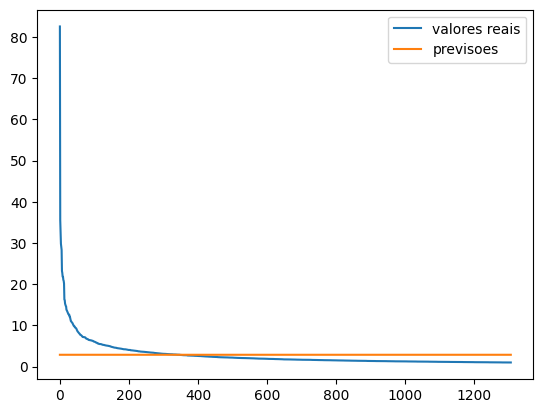

In [50]:
plt.plot(vendas)
plt.plot(previsoes)
plt.legend((['valores reais', 'previsoes']));
